In [34]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [35]:
N = 1000
series = np.sin(0.1 * np.arange(N)) + np.random.randn(N) * 0.1

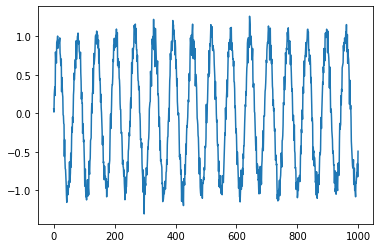

In [36]:
plt.plot(series)

In [37]:
## Build the dataset
# Let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t + T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape",X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


In [38]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Define Simple RNN

In [39]:
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super().__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        # Note : batch_first=True
        # applies the convention that our data will be of shape :
        # (num_samples, sequence_length, num_features)
        # rather than:
        # (sequence_length, num_samples, num_features)
        self.rnn = nn.RNN(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            nonlinearity='relu',
            batch_first=True
        )
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        # Initialize initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        # Get RNN unit output
        # out is of size (N, T, M)
        # 2nd return value is hidden states at each hidden layer
        # we don't need those for now
        out, _ = self.rnn(X, h0)
        
        # we only want h(T) at the final time step
        # N x M -> N x K
        out = self.fc(out[:, -1, :])
        return out

In [40]:
# Instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden= 5, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [41]:
# Loss Function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [42]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [43]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_train.to(device), y_train.to(device)

In [44]:
# Training
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    # Shuffle to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        loss.backward()
        optimizer.step()
        
        train_losses[epoch] = loss.item()
        
        test_pred = model(X_test)
        test_loss = criterion(test_pred, y_test)
        test_losses[epoch] = test_loss.item() 
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}]. Train Loss : {loss.item():.4f}. Test Loss : {test_loss.item():.4f}')
            
    return train_losses, test_losses

In [45]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

Epoch [5/200]. Train Loss : 0.2462. Test Loss : 0.1917
Epoch [10/200]. Train Loss : 0.1056. Test Loss : 0.0924
Epoch [15/200]. Train Loss : 0.0456. Test Loss : 0.0348
Epoch [20/200]. Train Loss : 0.0368. Test Loss : 0.0381
Epoch [25/200]. Train Loss : 0.0255. Test Loss : 0.0280
Epoch [30/200]. Train Loss : 0.0290. Test Loss : 0.0264
Epoch [35/200]. Train Loss : 0.0279. Test Loss : 0.0283
Epoch [40/200]. Train Loss : 0.0255. Test Loss : 0.0257
Epoch [45/200]. Train Loss : 0.0260. Test Loss : 0.0256
Epoch [50/200]. Train Loss : 0.0258. Test Loss : 0.0258
Epoch [55/200]. Train Loss : 0.0251. Test Loss : 0.0252
Epoch [60/200]. Train Loss : 0.0251. Test Loss : 0.0250
Epoch [65/200]. Train Loss : 0.0251. Test Loss : 0.0251
Epoch [70/200]. Train Loss : 0.0250. Test Loss : 0.0251
Epoch [75/200]. Train Loss : 0.0250. Test Loss : 0.0250
Epoch [80/200]. Train Loss : 0.0250. Test Loss : 0.0250
Epoch [85/200]. Train Loss : 0.0250. Test Loss : 0.0250
Epoch [90/200]. Train Loss : 0.0250. Test Loss : 

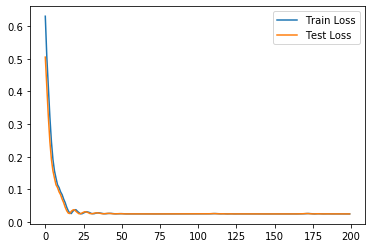

In [46]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

In [47]:
# "Wrong" forecase using true targets
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].view(1, T,-1)
    p = model(input_)[0,0].item() # 1x1 array -> scaler
    i += 1
    
    validation_predictions.append(p)

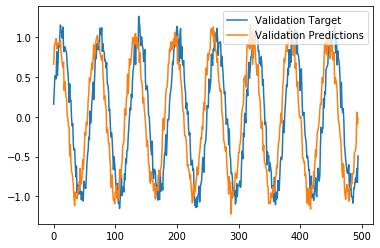

In [48]:
plt.plot(validation_target, label="Validation Target")
plt.plot(validation_predictions, label="Validation Predictions")
plt.legend()
plt.show()

In [49]:
# Forcast future values (use only self-predictions for making future predictions)
validation_target = Y[-N//2:]
validation_predictions = []

# Last Train Input
# 1-D Array of length T
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    
    validation_predictions.append(p[0,0].item())
    
    last_x = torch.cat((last_x[1:], p[0]))

In [50]:
last_x

tensor([0.1548, 0.1548, 0.1548, 0.1548, 0.1548, 0.1548, 0.1548, 0.1548, 0.1548,
        0.1548], device='cuda:0', grad_fn=<CatBackward>)

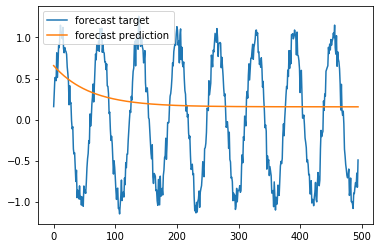

In [51]:
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast prediction")
plt.legend()